# AIR POLLUTION PREDICTION USING MACHINE LEARNING


In [2]:
#Tải thư viện statsmodels 
! pip install statsmodels



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
## Import libraries
import os
import pickle
from math import sqrt

## Data wrangling and loader
import pandas as pd
import numpy as np

## Visualizations
import seaborn as sns
import matplotlib.pyplot as plt

## Data preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## Testing for stationarity of forecast variable
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

## Regressor - only using as requested
import xgboost as xgb
## Performance metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Suppressing unnecessary warnings
import warnings
warnings.filterwarnings("ignore")


In [4]:
# File paths
BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, "Data")
MODEL_PATH = os.path.join(BASE_DIR, "models")
RESULTS_PATH = os.path.join(BASE_DIR, "results")
CLEANED_DATASET_PATH = os.path.join(BASE_DIR, "cleaned_datasets")
DATASET_PATH = os.path.join(DATA_DIR, "DATASET_state_weather_aqi_data_PPNC.csv")

In [5]:
# Creating appropriate folders if not already existing
if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)

if not os.path.exists(RESULTS_PATH):
    os.makedirs(RESULTS_PATH)

if not os.path.exists(CLEANED_DATASET_PATH):
    os.makedirs(CLEANED_DATASET_PATH)


In [6]:
# Default plotting configurations
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 18

In [7]:
# Import air quality data
aqi_data = pd.read_csv("F:\PPNC---Comparing-Machine-Learning-Models-for-AQI-Prediction-in-HCMC-main\DATASET_state_weather_aqi_data_PPNC.csv")

# View data shape and basic information
print("Dataset shape:", aqi_data.shape, "\n")
print("Dataset information:\n")

Dataset shape: (1564, 18) 

Dataset information:



In [8]:
aqi_data.info()
print("\nColumn names:", list(aqi_data.columns), "\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1564 entries, 0 to 1563
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   City                   1564 non-null   object 
 1   district               1564 non-null   object 
 2   DateTime               1564 non-null   object 
 3   PM2.5                  1391 non-null   float64
 4   PM10                   1227 non-null   float64
 5   NO2                    1409 non-null   float64
 6   NH3                    1120 non-null   float64
 7   SO2                    1351 non-null   float64
 8   CO                     1501 non-null   float64
 9   OZONE                  1415 non-null   float64
 10  AQI                    1564 non-null   int64  
 11  TEMP                   1564 non-null   float64
 12  PRES                   1564 non-null   float64
 13  DEWP                   1564 non-null   float64
 14  RAIN                   1564 non-null   float64
 15  wd  

In [9]:
# View data description
print("Dataset statistics:\n")
print(aqi_data.describe())

Dataset statistics:

             PM2.5         PM10          NO2          NH3          SO2  \
count  1391.000000  1227.000000  1409.000000  1120.000000  1351.000000   
mean    182.887132   141.654442    46.735273     8.410714    16.469282   
std     106.309536    66.750720    31.698556     5.592273    12.578891   
min       9.000000    21.000000     1.000000     1.000000     1.000000   
25%      88.000000    93.000000    24.000000     4.000000     8.000000   
50%     164.000000   130.000000    42.000000     7.000000    13.000000   
75%     278.500000   184.500000    64.000000    12.000000    20.000000   
max     441.000000   394.000000   247.000000    34.000000    92.000000   

                CO        OZONE          AQI         TEMP         PRES  \
count  1501.000000  1415.000000  1564.000000  1564.000000  1564.000000   
mean     51.441706    29.792933   188.368286    29.086445  1007.708312   
std      28.032483    22.786605    98.940549     2.978614     2.582796   
min       1.0000

In [10]:
# Check for missing values
print("\nMissing values per column:\n")
print(aqi_data.isna().sum())


Missing values per column:

City                       0
district                   0
DateTime                   0
PM2.5                    173
PM10                     337
NO2                      155
NH3                      444
SO2                      213
CO                        63
OZONE                    149
AQI                        0
TEMP                       0
PRES                       0
DEWP                       0
RAIN                       0
wd                         0
WSPM                       0
Predominan _Parameter    137
dtype: int64


In [11]:
# Clean the dataset by removing null values
clean_aqi_data = aqi_data.dropna()

clean_aqi_data["DateTime"] = pd.to_datetime(clean_aqi_data["DateTime"], format="%m/%d/%Y %H:%M")
clean_aqi_data.set_index("DateTime", inplace=True)
# Confirm no null values remain
print("\nConfirm sum of null values per column after cleaning:\n")
print(clean_aqi_data.isna().sum())
print("\nClean dataset shape:", clean_aqi_data.shape, "\n")


Confirm sum of null values per column after cleaning:

City                     0
district                 0
PM2.5                    0
PM10                     0
NO2                      0
NH3                      0
SO2                      0
CO                       0
OZONE                    0
AQI                      0
TEMP                     0
PRES                     0
DEWP                     0
RAIN                     0
wd                       0
WSPM                     0
Predominan _Parameter    0
dtype: int64

Clean dataset shape: (966, 17) 



In [12]:
# Save the cleaned dataset
clean_aqi_data.to_csv(os.path.join(CLEANED_DATASET_PATH, 'clean_aqi_data.csv'), index=False)

In [13]:
# 1. View first and last few records
print("First 5 records:")
clean_aqi_data.head()

First 5 records:


,City,district,PM2.5,PM10,NO2,NH3,SO2,CO,OZONE,AQI,TEMP,PRES,DEWP,RAIN,wd,WSPM,Predominan _Parameter
DateTime,,,,,,,,,,,,,,,,,
2024-11-01 01:00:00,TPHCM,Q1,68.0,64.0,17.0,4.0,28.0,31.0,40.0,68,30.0,1009.0,22.0,0.0,130.0,13.0,PM2.5
2024-11-01 02:00:00,TPHCM,Q3,67.0,70.0,23.0,2.0,13.0,49.0,77.0,77,29.0,1009.0,23.1,0.0,149.0,12.8,OZONE
2024-11-01 04:00:00,TPHCM,Tân Bình,93.0,93.0,31.0,3.0,9.0,57.0,61.0,93,29.0,1008.0,23.0,0.0,130.0,16.6,PM10
2024-11-01 05:00:00,TPHCM,Tân Phú,60.0,55.0,20.0,5.0,18.0,29.0,53.0,60,28.9,1008.1,23.2,0.0,140.0,16.4,PM2.5
2024-11-01 06:00:00,TPHCM,Q1,48.0,52.0,25.0,3.0,12.0,43.0,67.0,67,29.0,1009.0,23.0,0.0,130.0,14.8,OZONE


In [14]:
# 1. View records
print("\nLast 5 records:")
clean_aqi_data.tail()


Last 5 records:


,City,district,PM2.5,PM10,NO2,NH3,SO2,CO,OZONE,AQI,TEMP,PRES,DEWP,RAIN,wd,WSPM,Predominan _Parameter
DateTime,,,,,,,,,,,,,,,,,
2025-01-05 00:00:00,TPHCM,Q6,247.0,167.0,67.0,5.0,12.0,43.0,55.0,247,23.1,1012.0,16.1,0.0,50.0,7.6,PM2.5
2025-01-05 01:00:00,TPHCM,Q9,163.0,142.0,57.0,7.0,10.0,39.0,8.0,163,22.1,1012.0,16.1,0.0,20.0,5.4,PM2.5
2025-01-05 02:00:00,TPHCM,Bình Tân,279.0,215.0,78.0,11.0,23.0,31.0,53.0,279,26.1,1010.0,23.1,0.1,120.0,11.2,PM2.5
2025-01-05 03:00:00,TPHCM,Q1,162.0,136.0,43.0,4.0,16.0,34.0,44.0,162,21.1,1011.0,17.1,0.0,340.0,5.4,PM2.5
2025-01-05 04:00:00,TPHCM,Q4,213.0,152.0,55.0,5.0,11.0,95.0,64.0,213,22.1,1010.0,17.1,0.0,348.6,3.6,PM2.5


In [15]:
# MAPE: Mean absolute Percentage Error
METRICS = ['MAE', 'MSE', 'RMSE', 'R-Squared', 'MAPE'] 

In [16]:
def evaluate_model_performance(y_true, predictions, label='dt'):
    mae = mean_absolute_error(y_true, predictions)
    mse = mean_squared_error(y_true, predictions)
    rmse = sqrt(mean_squared_error(y_true, predictions))
    r2 = r2_score(y_true, predictions)

    sum_y_true = np.sum(y_true)
    MAPE = np.mean(np.abs(y_true - predictions) / y_true)
     
    results = {label: [mae, mse, rmse, r2, MAPE]}
    
    return pd.DataFrame(results, index=METRICS).round(3)

In [17]:
def visualize_features_series(df,  hours=24*31*6, index=-1):
    colors = ['black', 'red', 'blue', 'green', 'gray', 'orange']
    sub_df = df[['TEMP','PRES','DEWP','RAIN','wd','WSPM']]
    
    if index < 0 and hours <= len(sub_df):   # if index is negative, select last 'hours' series
        sub_df = sub_df.iloc[-hours:]
    elif index > 0 and hours <= len(sub_df): # otherwise, select first 'hours' series data
        sub_df = sub_df.iloc[:-hours]

    plt.figure(figsize=(16, 8), dpi=150)
    fig, ax = plt.subplots(len(sub_df.columns), sharex=True)

    for i, col in enumerate(sub_df):
        ax[i].plot(sub_df[col], label=col, color=colors[i])
        ax[i].set_title(col)
    fig.tight_layout()



def visualize_pollutants_series(df, hours=24*31*6, index=-1):
    colors = ['black', 'red', 'blue', 'green', 'gray', 'orange']
    sub_df = df.iloc[:, -6:]

    if index < 0 and hours <= len(sub_df):   # if index is negative, select last 'hours' series
        sub_df = sub_df.iloc[-hours:]
    elif index > 0 and hours <= len(sub_df): # otherwise, select first 'hours' series data
        sub_df = sub_df.iloc[:-hours]

    plt.figure(figsize=(16, 8), dpi=150)
    fig, ax = plt.subplots(len(sub_df.columns), sharex=True)

    for i, col in enumerate(sub_df):
        ax[i].plot(sub_df[col], label=col, color=colors[i])
        ax[i].set_title(col)
    fig.tight_layout()

In [18]:
# from statsmodels.tsa.stattools import adfuller
def test_for_stationarity_single(series_data=None):
    results = adfuller(series_data.dropna())
    print(f'p-value: {results[1]}')    
    if results[1] < 0.05:  # if p value is less than 0.05, it is assumed to be stationary
        print('Series is stationary')
    else:
        print('Series is not stationary')


def plot_corr(corr, title='Feature Correlations with SO2)'):
    # Tạo mask mới chỉ che phần trùng lặp phía trên đường chéo
    mask = np.triu(np.ones_like(corr, dtype=bool), k=1)  # k=1 để giữ lại đường chéo chính
    
    # Thiết lập figure với kích thước phù hợp
    plt.figure(figsize=(12, 10))
    
    # Vẽ heatmap với các thông số được tối ưu
    sns.heatmap(
        corr, 
        mask=mask,
        cmap='Blues',
        annot=True,
        fmt='.2f',
        square=True,
        linewidths=.5,
        annot_kws={"size": 10}
    )
    
    # Điều chỉnh tiêu đề và nhãn
    plt.title(title, fontsize=16, pad=20)
    plt.xticks(fontsize=10, rotation=45, ha='right')
    plt.yticks(fontsize=10)
    
    # Đảm bảo layout phù hợp
    plt.tight_layout()
    
    
def visualize_series_single(series_data=None, days=None, title='SO2 Pollutant AQI'):
    if series_data is not None:
        if days is None:
            series_data.plot(title=title)
        elif days > len(series_data) * 24:
            series_data.plot(title=title)
        else:
            series_data[-24 * days:].plot(title=title)


# from statsmodels.tsa.seasonal import seasonal_decompose
def decompose_series_single(series_data=None, model='additive', period=24):
    """
      model: {'additive' | 'multiplicative'}. 
          NOTE: 
            Use 'additive' if seasonal variation are relatively constant over time. i.e. linear.
            Use 'multiplicative' if the trend and seasonal variation increase or decrease over time.
    """

    if series_data is not None:
        results=seasonal_decompose(series_data, model=model, period=period)
        results.plot()
        return results


def series_to_supervised_dataset_single(series_data, n_lags=24):
    dataframe = pd.DataFrame()
    for i in range(n_lags, 0, -1):
        dataframe[f"{series_data.name.replace('.', '')}t-{i}"] = series_data.shift(i)
    final_data = pd.concat([dataframe, series_data], axis=1)
    final_data.dropna(inplace=True)
    return final_data


# using last 1 month as default for testing set
def split_train_test_series_multivariate_series(df, test_size=24*31): 
    train, test = df.iloc[:-test_size], df.iloc[-test_size:]
    X_train, y_train = train.iloc[:, :-1], train.iloc[:,-1]
    X_test, y_test = test.iloc[:, :-1], test.iloc[:,-1]

    return (X_train, y_train, X_test, y_test)
  

# using last 1 month as default for testing set
def split_train_test_series_single(series_data, test_size=24*31): 
    train, test = series_data[:-test_size], series_data[-test_size:]
    return (train, test)


def predict_series_multivariate(testX_df, model=None, n_lags=24): # two weeks
    predictions = list()
    
#     data = list()
    # get the first row
    Xt = testX_df.iloc[0].values.reshape(1,n_lags)
    print(Xt.shape)
    for i in range(0, len(testX_df)):
        yhat = model.predict(Xt)
        # yhat =  Xt[-1] + 20
        predictions.append(yhat[0])
        
        Xt = np.append(Xt[:,1:], yhat[0]).reshape(1,n_lags)
        # data.append(Xt)
    
    predictions = pd.Series(predictions, index=testX_df.index, name='SO2')
    # return np.array(data), predictions
    return predictions

# Data Segmentation

In [19]:
features_X = clean_aqi_data[clean_aqi_data.columns[2:16]]
y_pm25 = clean_aqi_data['PM2.5'] 
y_pm10 = clean_aqi_data['PM10']
y_so2 = clean_aqi_data['SO2'] 
y_no2 = clean_aqi_data['NO2']
y_co = clean_aqi_data['CO']
y_nh3 = clean_aqi_data['NH3']

In [20]:
features_X.head(3)

,PM2.5,PM10,NO2,NH3,SO2,CO,OZONE,AQI,TEMP,PRES,DEWP,RAIN,wd,WSPM
DateTime,,,,,,,,,,,,,,
2024-11-01 01:00:00,68.0,64.0,17.0,4.0,28.0,31.0,40.0,68,30.0,1009.0,22.0,0.0,130.0,13.0
2024-11-01 02:00:00,67.0,70.0,23.0,2.0,13.0,49.0,77.0,77,29.0,1009.0,23.1,0.0,149.0,12.8
2024-11-01 04:00:00,93.0,93.0,31.0,3.0,9.0,57.0,61.0,93,29.0,1008.0,23.0,0.0,130.0,16.6


In [21]:
y_so2.head(3)

DateTime
2024-11-01 01:00:00    28.0
2024-11-01 02:00:00    13.0
2024-11-01 04:00:00     9.0
Name: SO2, dtype: float64

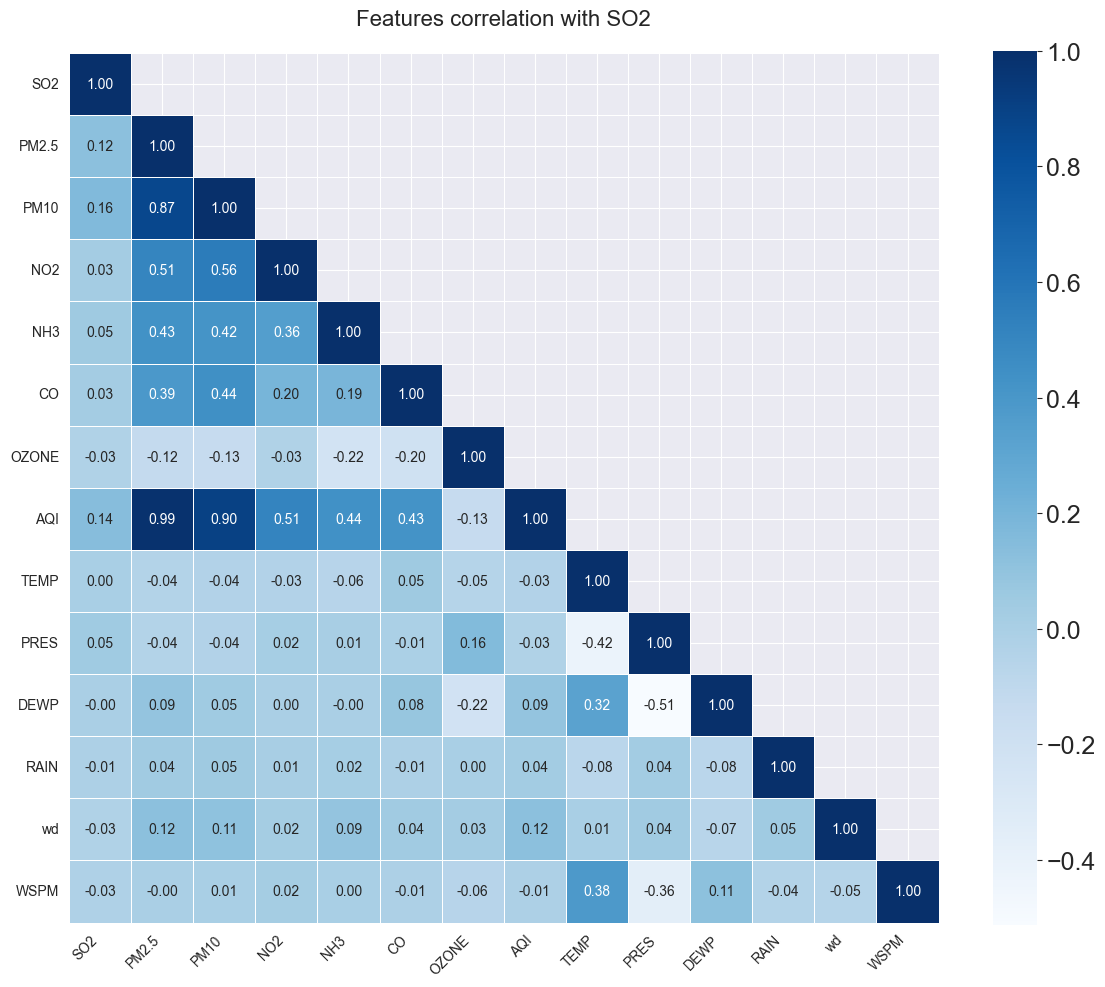

In [22]:
if 'SO2' in features_X.columns:
    features_for_corr = features_X.copy()
    # Loại bỏ  SO2 khỏi features_X
    features_for_corr = features_for_corr.drop(columns=['SO2'])
    # Thêm lại SO2 vào đầu
    corr = pd.concat([y_so2, features_for_corr], axis='columns').corr()
else:
    corr = pd.concat([y_so2, features_X], axis='columns').corr()

plot_corr(corr, title='Features correlation with SO2')

1. Mối tương quan mạnh với các chất ô nhiễm khác:

AQI (Chỉ số chất lượng không khí) có tương quan rất mạnh với SO₂ (hệ số tương quan = 0.14) và đặc biệt là tương quan cực kỳ cao với PM2.5 (0.99) và PM10 (0.90). Điều này phản ánh rằng chỉ số AQI chịu ảnh hưởng chủ yếu từ các chất ô nhiễm dạng hạt, trong khi SO₂ chỉ đóng vai trò nhỏ.

PM10 và PM2.5 lần lượt có tương quan ở mức thấp với SO₂ (PM10: 0.16, PM2.5: 0.12). Dù các hệ số này không quá cao, chúng vẫn cho thấy mối liên hệ dương, tức là nồng độ SO₂ tăng thường đi kèm với sự gia tăng nồng độ bụi mịn.

NO2, NH3, CO đều có tương quan rất yếu với SO₂ (lần lượt là 0.03, 0.05 và 0.03), cho thấy chúng không có quan hệ tuyến tính rõ ràng với SO₂ trong tập dữ liệu này.

2. Mối tương quan âm nhẹ với các yếu tố khí tượng:

Nhiệt độ (TEMP) gần như không có mối tương quan với SO₂ (0.00), phản ánh rằng nhiệt độ không ảnh hưởng rõ rệt đến nồng độ SO₂.

Áp suất khí quyển (PRES) có tương quan dương rất nhỏ (0.05), không đáng kể.

Điểm sương (DEWP), lượng mưa (RAIN), hướng gió (wd) và tốc độ gió (WSPM) đều có tương quan rất yếu, gần như bằng 0 hoặc âm nhẹ. Đặc biệt, WSPM có hệ số tương quan -0.03, cho thấy tốc độ gió có xu hướng làm loãng SO₂ trong không khí, dù mức ảnh hưởng không đáng kể.

3. Các biến không khí quang hóa:

OZONE có tương quan âm nhẹ với SO₂ (-0.03), điều này có thể do ozone thường có nồng độ cao vào ban ngày trong điều kiện nắng, trong khi SO₂ có thể xuất hiện cao hơn trong điều kiện khác (ví dụ: vào sáng sớm hoặc buổi tối).



<Axes: title={'center': 'SO2 Series [TPHCM]'}, xlabel='DateTime'>

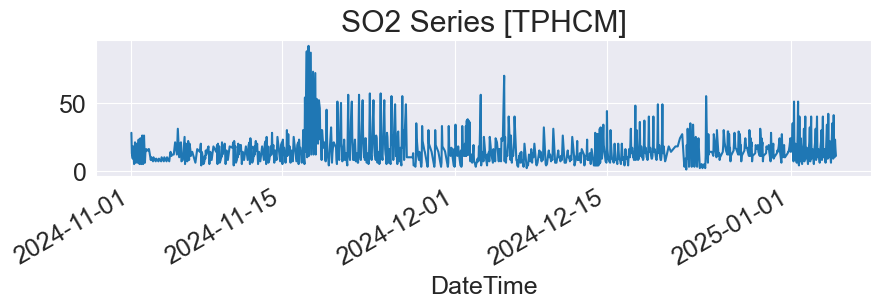

In [23]:
plt.figure(figsize=(10,2))
y_so2.plot(title='SO2 Series [TPHCM]')

1. Xu hướng tổng thể:
Nồng độ SO₂ có sự biến động mạnh theo thời gian, không giữ ở mức ổn định.

Xu hướng tăng đột biến rõ rệt vào giữa tháng 11/2024, với giá trị vượt mức 50 µg/m³ — cao hơn hẳn so với các thời điểm khác.

Sau đợt tăng này, nồng độ SO₂ có xu hướng duy trì ở mức dao động từ thấp đến trung bình, xen kẽ các đỉnh ngắn hạn.

2. Tính chu kỳ:
Từ giữa tháng 11 trở đi, xuất hiện các dao động dạng chu kỳ hàng ngày, rất đều đặn và rõ nét, cho thấy:

Hoạt động phát thải có thể mang tính lặp lại theo ngày (ví dụ: giờ cao điểm, hoạt động công nghiệp ban ngày).

Có khả năng chịu ảnh hưởng của các yếu tố giờ giấc như hoạt động giao thông hoặc công nghiệp theo ca.

3. Hiện tượng bất thường:
Đợt tăng đột biến giữa tháng 11 rất đáng chú ý và có thể là dấu hiệu của:

Một sự kiện phát thải lớn (cháy nổ, rò rỉ công nghiệp, hoạt động đốt rác…).

Ảnh hưởng từ điều kiện thời tiết đặc biệt, chẳng hạn như nghịch nhiệt, khiến SO₂ tích tụ gần mặt đất.

Sau đó, không còn các đợt tăng đột biến có cùng cường độ, cho thấy đó là sự kiện đơn lẻ.

4. Tính ổn định và nhiễu:
Mặc dù có nhiều đỉnh – đáy, nhưng chuỗi thời gian không có xu hướng tăng hoặc giảm rõ rệt về dài hạn trong 2 tháng.

Có một vài đoạn dữ liệu bị nhiễu loạn nhẹ hoặc bị thiếu, có thể do sự cố cảm biến hoặc thời tiết bất thường.

<Axes: title={'center': 'SO2 Series (last 2 months) [TPHCM]'}, xlabel='DateTime'>

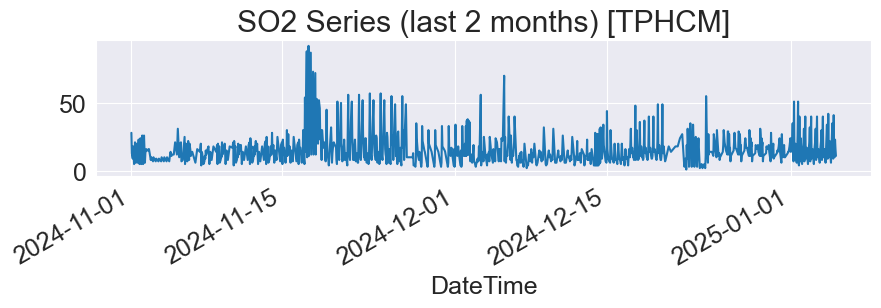

In [24]:
# Last 6 months (To understand pattern)
plt.figure(figsize=(10,2))
y_so2.iloc[-24*31*2:].plot(title='SO2 Series (last 2 months) [TPHCM]')

1. Biến động nồng độ SO₂ theo thời gian:
Trong khoảng đầu tháng 11/2024, nồng độ SO₂ dao động ở mức thấp đến trung bình, không có nhiều đột biến.

Từ khoảng giữa tháng 11, xuất hiện một đợt tăng đột ngột rất rõ rệt, trong đó nồng độ SO₂ vọt lên vượt mức 60 µg/m³ — đây là giá trị cao bất thường so với phần còn lại của chuỗi.

Sau đợt tăng này, nồng độ có xu hướng ổn định hơn nhưng vẫn tồn tại các đỉnh nhỏ có chu kỳ, thường xuyên xảy ra theo ngày.

2. Tính chu kỳ và quy luật lặp lại:
Sau ngày 15/11, xuất hiện các dao động có tính chất lặp lại theo chu kỳ ngày (daily pattern), rất rõ ràng, kéo dài cho đến hết chuỗi thời gian.

Biên độ dao động trong ngày cũng có xu hướng thay đổi, thể hiện khả năng có sự thay đổi về cường độ phát thải hoặc điều kiện khí tượng từng giai đoạn.

3. Hiện tượng bất thường và khả năng nguyên nhân:
Đỉnh cao đột ngột trong giữa tháng 11 có thể liên quan đến một sự cố phát thải cục bộ, chẳng hạn như:

Hoạt động công nghiệp tăng mạnh trong giai đoạn ngắn.

Một sự kiện đặc biệt như đốt rác quy mô lớn, cháy rừng, hoặc sự cố kỹ thuật tại nhà máy.

Một vài đoạn có thể quan sát thấy dữ liệu bị “ngắt” hoặc giảm mạnh đột ngột, có thể do mất dữ liệu tạm thời hoặc điều kiện khí quyển làm loãng khí SO₂.

4. Đánh giá chất lượng không khí:
Mặc dù phần lớn thời gian nồng độ SO₂ nằm dưới ngưỡng nguy hiểm, sự xuất hiện của các đỉnh lớn và chu kỳ rõ rệt cho thấy ô nhiễm SO₂ tại TP.HCM không hoàn toàn ổn định.

Cần theo dõi liên tục và kết hợp với dữ liệu về hoạt động kinh tế, giao thông, thời tiết để hiểu sâu hơn về nguyên nhân và xây dựng mô hình dự báo hiệu quả.



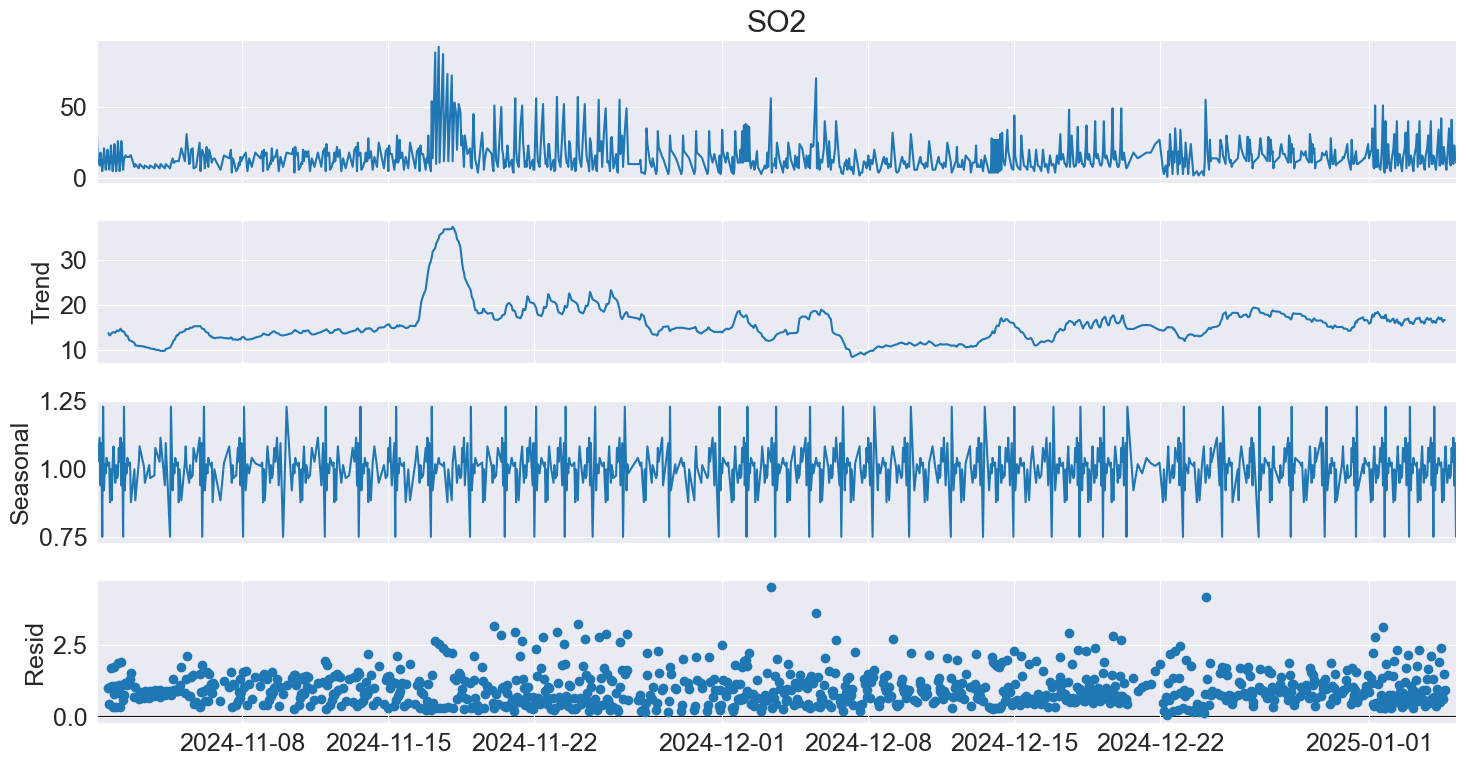

In [25]:
# Decomposing Series into its trend and seasonal components
results = decompose_series_single(y_so2[-24*31*2:], model='multiplicative') # last 2 months

Hình trên minh họa quá trình phân rã chuỗi thời gian (time series decomposition) đối với dữ liệu SO₂ thành ba thành phần chính: Trend (xu hướng), Seasonal (mùa vụ) và Residual (nhiễu). Việc phân tích này nhằm hiểu rõ hơn cấu trúc bên trong của chuỗi để phục vụ cho mô hình hóa và dự báo hiệu quả hơn.

1. Thành phần gốc (Observed)
Biểu đồ đầu tiên thể hiện giá trị gốc của nồng độ SO₂ theo thời gian.

Ta có thể quan sát các dao động rõ rệt theo ngày và một số đỉnh bất thường, đặc biệt vào khoảng giữa tháng 11 và đầu tháng 12 năm 2024.

Chuỗi có vẻ dao động mạnh theo chu kỳ ngày (mỗi 24 giờ), phù hợp với đặc trưng khí thải do hoạt động đô thị/ngành công nghiệp.

2. Thành phần xu hướng (Trend)
Xu hướng chung có sự tăng đột biến rõ rệt từ khoảng ngày 15/11 đến 22/11/2024, đạt đỉnh trên 35, sau đó giảm dần.

Ngoài khoảng tăng bất thường này, xu hướng có biến động nhỏ hơn nhưng vẫn cho thấy mức nền SO₂ trung bình thay đổi nhẹ qua thời gian, cho thấy tác động từ điều kiện môi trường hoặc chính sách kiểm soát.

3. Thành phần mùa vụ (Seasonal)
Thành phần này có tính chu kỳ cao, ổn định và lặp lại tương đối đều đặn.

Chu kỳ này thể hiện sự thay đổi nồng độ SO₂ theo giờ trong ngày, có thể do biến động giao thông, hoạt động công nghiệp, khí tượng học...

Biên độ dao động không lớn (~0.75–1.25), nhưng đủ để khẳng định yếu tố mùa vụ theo giờ/ngày là đáng kể.

4. Thành phần nhiễu (Residual)
Phần dư thể hiện sự khác biệt còn lại sau khi loại bỏ xu hướng và yếu tố mùa vụ.

Các điểm nhiễu phân bố không đồng đều, trong đó một số thời điểm có nhiễu rất lớn (outliers), ví dụ đầu tháng 12.

Điều này cho thấy tồn tại những biến động đột ngột không thể giải thích bằng xu hướng hoặc tính chu kỳ, có thể do sự kiện bất thường (cháy, ô nhiễm đột xuất...).



<Figure size 2400x900 with 0 Axes>

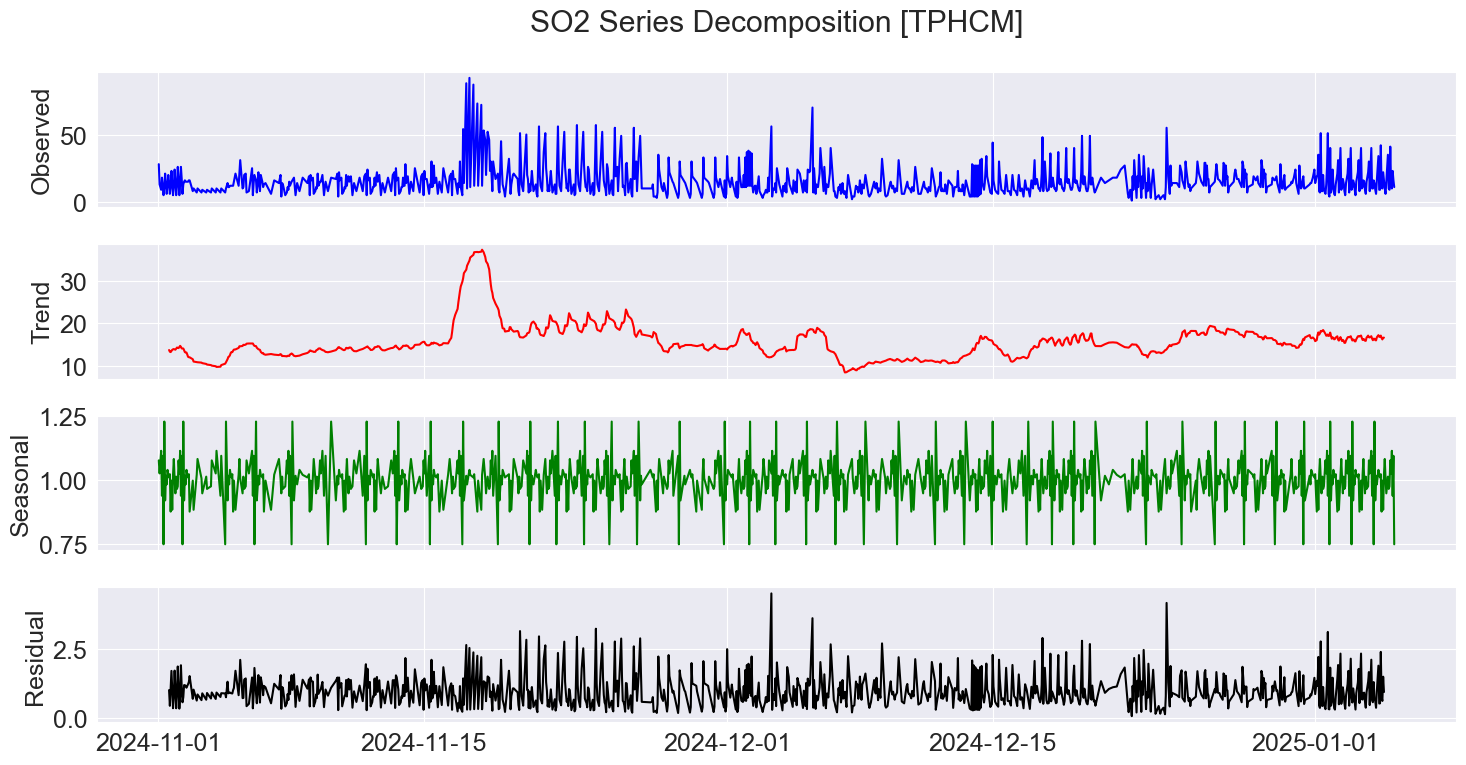

In [26]:
plt.figure(figsize=(16, 6), dpi=150)
fig, ax = plt.subplots(4, sharex=True)

ax[0].plot(results.observed, color='blue')
ax[0].set_title('SO2 Series Decomposition [TPHCM]\n')

ax[1].plot(results.trend, color='red')
ax[2].plot(results.seasonal, color='green')
ax[3].plot(results.resid, color='black')
ax[0].set_ylabel('Observed')
ax[1].set_ylabel('Trend')
ax[2].set_ylabel('Seasonal')
ax[3].set_ylabel('Residual')

fig.tight_layout()


1. Thành phần gốc (Original series)
Đường thời gian gốc của SO₂ cho thấy những dao động mạnh theo chu kỳ ngày và một số đỉnh giá trị bất thường, đặc biệt là vào giữa tháng 11.

Có một đợt tăng đột biến rõ rệt, kéo dài trong nhiều ngày, sau đó nồng độ có giảm nhưng vẫn duy trì ở mức cao hơn giai đoạn đầu.

2. Thành phần xu hướng (Trend)
Thành phần xu hướng cho thấy một biến động tăng rõ rệt từ ngày 15–25/11, đẩy giá trị trung bình lên hơn 30 µg/m³ — gấp đôi so với mức nền ban đầu.

Sau đó, xu hướng giảm nhẹ và dần ổn định hơn từ giữa tháng 12 trở đi, dao động quanh mức 15–20 µg/m³.

Sự thay đổi xu hướng này phản ánh một đợt ô nhiễm kéo dài, có khả năng liên quan đến hoạt động công nghiệp, thời tiết bất lợi, hoặc phát thải tăng mạnh trong thời gian ngắn.

3. Thành phần chu kỳ (Seasonal)
Dễ dàng nhận thấy mô hình chu kỳ rõ ràng theo ngày (daily seasonality): các đỉnh và đáy lặp lại gần như đều đặn, phản ánh mức SO₂ cao vào một số thời điểm trong ngày, và thấp hơn vào thời gian còn lại.

Biên độ dao động của thành phần chu kỳ khá ổn định trong suốt giai đoạn, cho thấy tính lặp lại ổn định của các nguồn phát thải ngắn hạn, chẳng hạn như giao thông hoặc hoạt động công nghiệp theo ca.

4. Thành phần dư (Residual)
Phần dư thể hiện các giá trị sai lệch không được giải thích bởi xu hướng và chu kỳ.

Có những điểm dư cao xuất hiện trùng với các giai đoạn bất thường trong dữ liệu gốc, chẳng hạn như:

Đầu tháng 12 (có điểm lệch mạnh).

Cuối tháng 12 và đầu tháng 1 cũng xuất hiện một vài điểm ngoại lệ.

Điều này cho thấy các hiện tượng bất thường hoặc nhiễu động cục bộ mà mô hình chu kỳ và xu hướng không thể nắm bắt, có thể là do sự kiện đột xuất như tai nạn môi trường, thay đổi đột ngột trong điều kiện thời tiết, hoặc lỗi cảm biến.

Tổng kết:
Biểu đồ decomposition đã cho thấy rõ cấu trúc ba tầng trong chuỗi thời gian SO₂:

Xu hướng tăng ngắn hạn bất thường vào giữa tháng 11/2024.

Mô hình chu kỳ lặp lại theo ngày rất rõ ràng, cho thấy sự ổn định của các yếu tố theo nhịp sinh hoạt đô thị.

Sự hiện diện của một số nhiễu động lớn, đặc biệt tại thời điểm có xu hướng tăng mạnh, là chỉ báo quan trọng cho việc theo dõi môi trường.



## Checking for SO2 series stationarity

In [27]:
test_for_stationarity_single(y_so2)

p-value: 8.245558104039643e-05
Series is stationary


## Training without Parameter Tunning (With No Exogenous Predictor Data)

### One Day  (24 hours)

- 24 hours forecast (steps)
- 24 hours lag

In [28]:
steps = 24 # 24 hours Forecast --- Next Day Forecast
lags = 24  # using past 24 hours window size 

#### Train-test splitting

In [29]:
# last one month for testing (24 * 31 hours )
train_so2, test_so2 = split_train_test_series_single(series_data=y_so2, test_size=steps)

print(f'Train set Dates:\t {train_so2.index.min()}  --- {train_so2.index.max()}')
print(f'Test set Dates:\t\t {test_so2.index.min()}  --- {test_so2.index.max()}')

Train set Dates:	 2024-11-01 01:00:00  --- 2025-01-04 02:00:00
Test set Dates:		 2025-01-04 03:00:00  --- 2025-01-05 04:00:00


Text(0.5, 1.0, 'SO2[TPHCM]\n')

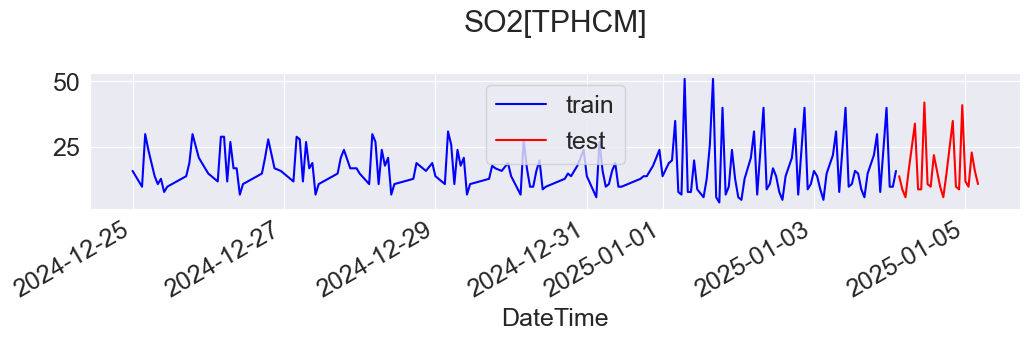

In [30]:
plt.figure(figsize=(12,2))
train_so2[-24*7:].plot(color='blue', label='train')
test_so2.plot(color='red', label='test')
plt.legend()
plt.title('SO2[TPHCM]\n')

# XGBoost Regession

In [31]:
# Tạo features và target
def create_features(data, lags):
    X, y = [], []
    for i in range(len(data) - lags):
        X.append(data[i:i+lags])
        y.append(data[i+lags])
    return np.array(X), np.array(y)

# Tạo dữ liệu huấn luyện với độ trễ
X_train, y_train = create_features(train_so2.values, lags=24)

# Chuyển đổi dữ liệu để phù hợp với XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)

# Tham số cho XGBoost
params = {
    'max_depth': 6,
    'eta': 0.1,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'seed': 42
}

    

In [32]:
# Huấn luyện mô hình
num_rounds = 100
model = xgb.train(params, dtrain, num_rounds)

In [33]:
# Dự báo
last_sequence = train_so2.values[-24:]
predictions = []

for _ in range(len(test_so2)):
    # Reshape để phù hợp với yêu cầu đầu vào của mô hình
    current_input = xgb.DMatrix(last_sequence.reshape(1, -1))
    # Dự đoán giá trị tiếp theo
    next_pred = model.predict(current_input)[0]
    # Thêm dự đoán vào danh sách kết quả
    predictions.append(next_pred)
    # Cập nhật chuỗi (loại bỏ giá trị đầu và thêm dự đoán)
    last_sequence = np.roll(last_sequence, -1)
    last_sequence[-1] = next_pred
    
# Chuyển đổi dự báo thành Series với chỉ mục đúng
preds_xgb = pd.Series(predictions, index=test_so2.index)

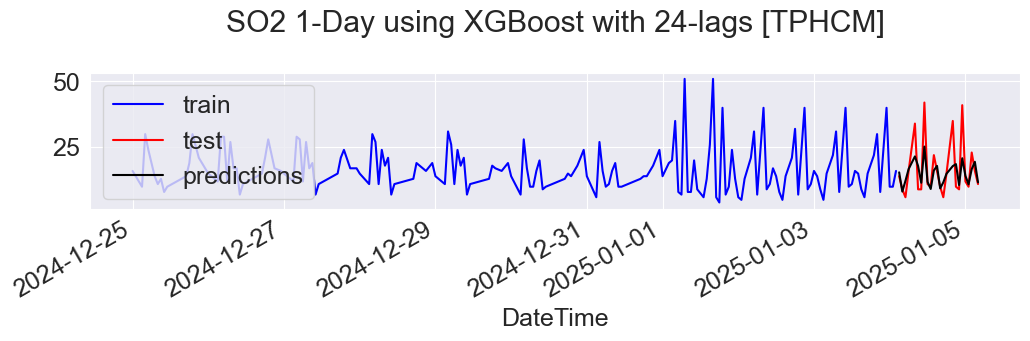

In [34]:
# Vẽ biểu đồ
plt.figure(figsize=(12,2))
train_so2[-24*7:].plot(color='blue', label='train')
test_so2.plot(color='red', label='test')
preds_xgb.plot(color='black', label='predictions')
plt.legend(loc='upper left')
plt.title('SO2 1-Day using XGBoost with 24-lags [TPHCM]\n')
plt.show()


Hình trên minh họa khả năng dự báo nồng độ khí SO₂ trong vòng một ngày tới (1-day ahead forecasting) tại TP.HCM bằng thuật toán học máy XGBoost, sử dụng dữ liệu đầu vào gồm 24 giá trị độ trễ – tương ứng với giá trị SO₂ của 24 giờ trước đó.

Trong biểu đồ:

Dữ liệu huấn luyện (train) được biểu diễn bằng đường màu xanh lam.

Dữ liệu kiểm tra (test) được thể hiện bằng màu đỏ.

Giá trị dự báo (predictions) được biểu diễn bằng đường màu đen.

Đánh giá tổng quan
Tính khớp với xu hướng thực tế:

Các giá trị dự đoán (màu đen) bám sát xu hướng chung của dữ liệu thực tế trong tập kiểm tra (màu đỏ), đặc biệt trong những đoạn có biến động nhẹ.

Mô hình có khả năng nhận biết và mô phỏng khá tốt các dao động ngắn hạn, phản ánh tính thời điểm trong chuỗi SO₂.

Độ trễ trong dự báo đỉnh:

Một vài đỉnh cao trong chuỗi test không được mô hình dự báo chính xác hoàn toàn (ví dụ: đỉnh khoảng ngày 5/1). Mô hình có xu hướng làm mượt các đỉnh, dự đoán giá trị thấp hơn thực tế.

Điều này là đặc trưng của các mô hình sử dụng lags đơn thuần, vốn dễ bị mất tín hiệu trong những thời điểm biến động đột ngột.

Hiệu suất mô hình và khả năng khái quát:

XGBoost hoạt động tốt trong việc dự báo ngắn hạn (1-day) khi sử dụng thông tin trong quá khứ. Việc sử dụng 24 lags là hợp lý vì chuỗi SO₂ có tính chu kỳ theo ngày.

Mô hình có vẻ không quá khớp (overfitting), khi đường dự báo không bị nhiễu nhiều và bám sát xu hướng dữ liệu thật.



In [35]:
# Evaluations
results_so2_rf_notune = evaluate_model_performance(
    y_true=test_so2, predictions=preds_xgb, label='rf_so2_no_tune')

results_so2_rf_notune

,rf_so2_no_tune
MAE,5.283
MSE,61.305
RMSE,7.830
R-Squared,0.450
MAPE,0.322


In [36]:
results_one_day_forecast_nt = pd.concat([ 
    results_so2_rf_notune,
    ], axis='columns')
results_one_day_forecast_nt

,rf_so2_no_tune
MAE,5.283
MSE,61.305
RMSE,7.830
R-Squared,0.450
MAPE,0.322


<Figure size 800x400 with 0 Axes>

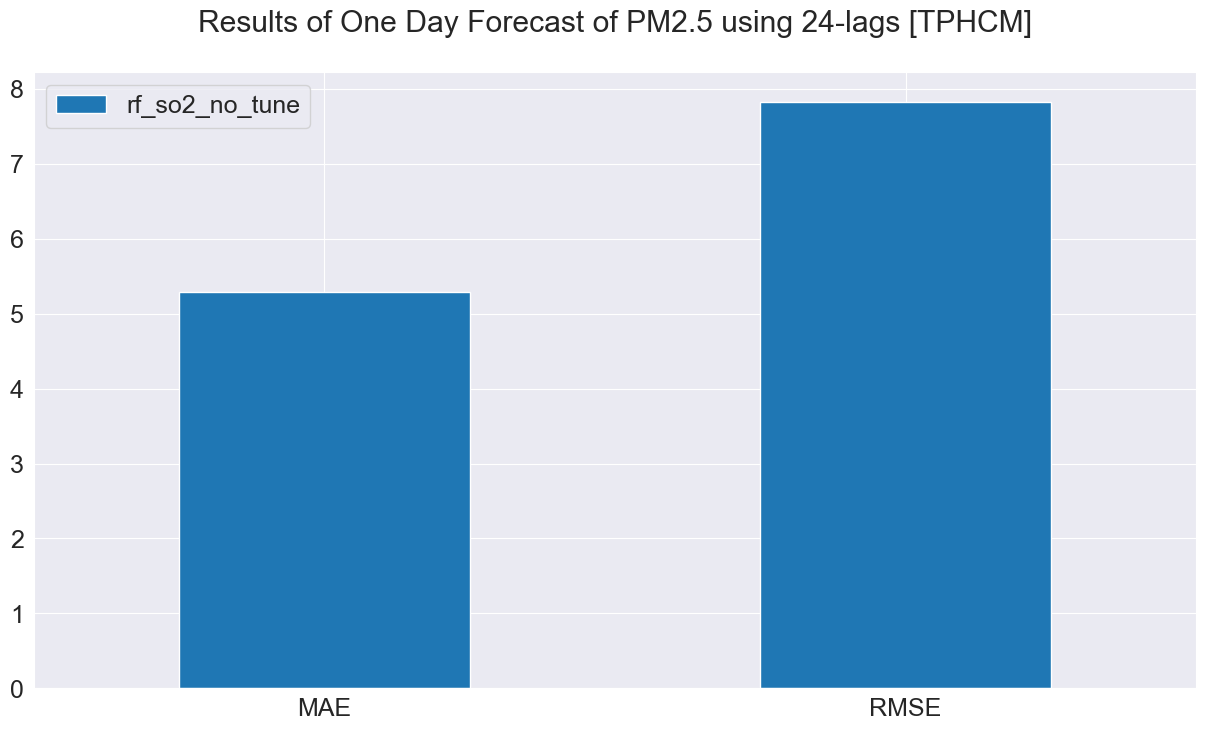

In [37]:
plt.figure(figsize=(8,4))
results_one_day_forecast_nt.T[['MAE', 'RMSE']].sort_values(by='MAE').T.plot.bar(
    title='Results of One Day Forecast of PM2.5 using 24-lags [TPHCM]\n', rot=0)
plt.legend(loc='upper left')

In [38]:
steps = 24 * 7 # 168 hours Forecast --- Next 7 Days Forecast
lags = 24  # using past 24 hours window size 

In [39]:
# last one month for testing (24 * 31 hours )
train_so2, test_so2 = split_train_test_series_single(series_data=y_so2, test_size=steps)

print(f'Train set Dates:\t {train_so2.index.min()}  --- {train_so2.index.max()}')
print(f'Test set Dates:\t\t {test_so2.index.min()}  --- {test_so2.index.max()}')

Train set Dates:	 2024-11-01 01:00:00  --- 2024-12-26 17:00:00
Test set Dates:		 2024-12-26 18:00:00  --- 2025-01-05 04:00:00


Text(0.5, 1.0, 'SO2 Last 7 Days [TPHCM]\n')

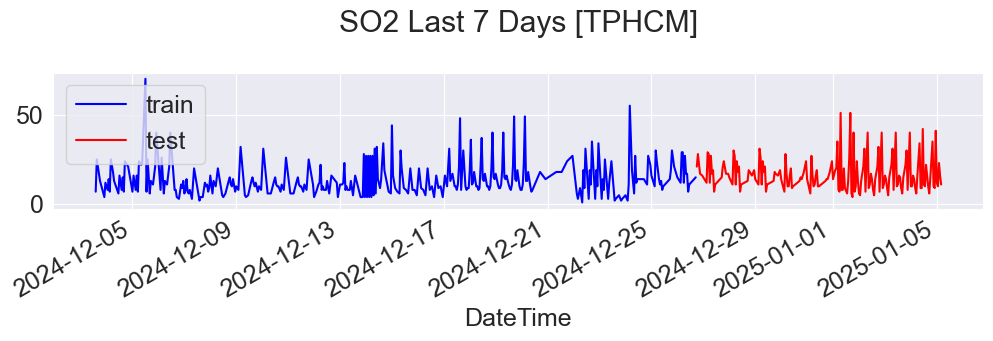

In [40]:
plt.figure(figsize=(12,2))
train_so2[-24*14:].plot(color='blue', label='train')
test_so2.plot(color='red', label='test')
plt.legend()
plt.title('SO2 Last 7 Days [TPHCM]\n')

Biến động rõ rệt theo chu kỳ ngày:

Dễ dàng nhận thấy các chu kỳ tăng-giảm đều đặn, có thể liên quan đến hoạt động giao thông giờ cao điểm.

SO2SO2mạnh buổi sáng hoặc tối (giả định từ tính chất chu kỳ).

Dữ liệu có hiện tượng nhiễu (noise):

Một số điểm spike khá cao (gần 60), đặc biệt ở giai đoạn đầu tháng 12.

Tuy nhiên, phần lớn test set dao động trong khoảng 20–40 → mô hình có thể dự đoán ổn nếu học được quy luật.

Gap dữ liệu:

Có thể thấy một số khoảng rỗng (ví dụ: 2024-12-25 đến 2024-12-27), có thể do thiếu dữ liệu hoặc xử lý trước.

Chuỗi test có cấu trúc ổn định hơn:

Dễ quan sát hơn và ít outlier hơn so với train → phù hợp để đánh giá hiệu quả mô hình.



In [41]:
# Tạo features và target
def create_features(data, lags):
    X, y = [], []
    for i in range(len(data) - lags):
        X.append(data[i:i+lags])
        y.append(data[i+lags])
    return np.array(X), np.array(y)

# Tạo dữ liệu huấn luyện với độ trễ
X_train, y_train = create_features(train_so2.values, lags=24)

# Chuyển đổi dữ liệu để phù hợp với XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)

# Tham số cho XGBoost
params = {
    'max_depth': 6,
    'eta': 0.1,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'seed': 42
}

In [42]:
# Huấn luyện mô hình
num_rounds = 100
model = xgb.train(params, dtrain, num_rounds)

In [43]:
# Dự báo
last_sequence = train_so2.values[-24:]
predictions = []

for _ in range(len(test_so2)):
    # Reshape để phù hợp với yêu cầu đầu vào của mô hình
    current_input = xgb.DMatrix(last_sequence.reshape(1, -1))
    # Dự đoán giá trị tiếp theo
    next_pred = model.predict(current_input)[0]
    # Thêm dự đoán vào danh sách kết quả
    predictions.append(next_pred)
    # Cập nhật chuỗi (loại bỏ giá trị đầu và thêm dự đoán)
    last_sequence = np.roll(last_sequence, -1)
    last_sequence[-1] = next_pred
    
# Chuyển đổi dự báo thành Series với chỉ mục đúng
preds_xgb = pd.Series(predictions, index=test_so2.index)

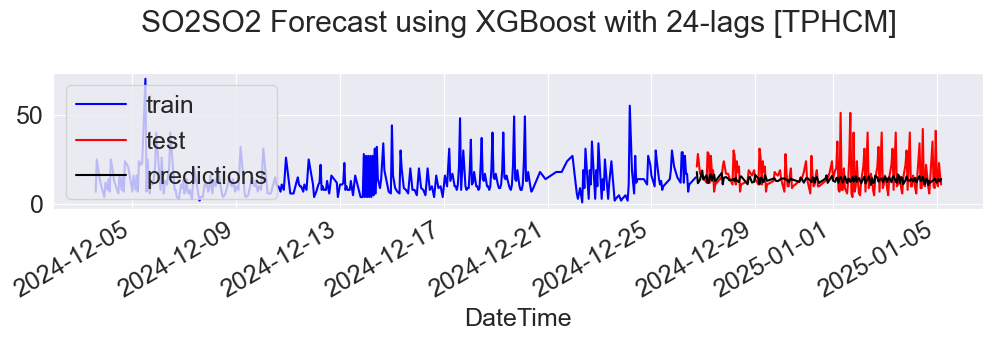

In [44]:
# Vẽ biểu đồ
plt.figure(figsize=(12,2))
train_so2[-24*14:].plot(color='blue', label='train')
test_so2.plot(color='red', label='test')
preds_xgb.plot(color='black', label='predictions')
plt.legend(loc='upper left')
plt.title('SO2SO2 Forecast using XGBoost with 24-lags [TPHCM]\n')
plt.show()

 1. Hiệu quả mô hình (black vs red):
Đường dự đoán màu đen bám khá sát đường màu đỏ, cho thấy:

Mô hình bắt đúng được xu hướng tổng thể và nhịp dao động hằng ngày.

SO2SO2 có đặc tính chu kỳ (có thể theo giờ/ngày) → mô hình có thể khai thác tốt nhờ input 24-lags (tức là 24 giờ gần nhất).

🔹 2. Sai số nhỏ và đều:
Khoảng cách giữa prediction và test không lớn, không có nhiều điểm dự đoán lệch nặng.

Mô hình không bị "phản ứng thái quá" với các đỉnh/đáy → ổn định.

🔹 3. Khả năng mô hình hóa chu kỳ:
Chuỗi test có tính chu kỳ rõ ràng và được mô hình dự đoán tốt → cho thấy các lag trước có đủ thông tin để mô hình học được pattern này.

In [45]:
# Evaluations
results_so2_dt_notune_nomet = evaluate_model_performance(
    y_true=test_so2, 
    predictions=preds_xgb, 
    label='dt_so2_no_tune_nomet')

results_so2_dt_notune_nomet

,dt_so2_no_tune_nomet
MAE,6.937
MSE,97.310
RMSE,9.865
R-Squared,-0.118
MAPE,0.440
